In [1]:
#0: imports

import uproot 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from dataAnalyse import CCV1
from torch_geometric.data import DataLoader 
from torch_geometric.nn import knn_graph

import numpy as np
import time
from Imports import Aggloremative, calculate_reco_to_sim_score, calculate_sim_to_reco_score, calculate_all_event_scores

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
#1: Load Data + Model
#1.1: Load Data Through the dataloader - used for predictions
testpath = "/vols/cms/mm1221/Data/le2pi/"
data_test = CCV1(testpath, max_events=15000, inp = 'test')
test_loader = DataLoader(data_test, batch_size=1, shuffle=False, follow_batch=['x'])



### Loading tracksters data


  0%|                                                                                                                                                                                 | 0/1 [00:00<?, ?it/s]

/vols/cms/mm1221/Data/le2pi/raw/step3_NTUPLE.root


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:44<00:00, 44.16s/it]
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [3]:
# load the model 
from model import Net
model = Net(
    hidden_dim=128,
    num_layers=4,
    dropout=0.3,
    contrastive_dim=16
)


#checkpoint= torch.load('/vols/cms/mm1221/hgcal/elec5New/Track/NegativeMining/resultslr5t54SECEXT/best_model.pt',  map_location=torch.device('cpu'))
checkpoint= torch.load('/vols/cms/mm1221/hgcal/pion5New/Track/NegativeMining/resultsSECNeg/best_model.pt',  map_location=torch.device('cpu'))

model.load_state_dict(checkpoint)  
model.eval()  

Net(
  (lc_encode): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
  )
  (convs): ModuleList(
    (0-3): 4 x CustomStaticEdgeConv(
      (nn_module): Sequential(
        (0): Linear(in_features=256, out_features=128, bias=True)
        (1): ELU(alpha=1.0)
        (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
  )
)

In [4]:

#3: Make Predictions + Cluster -> Calculate the inference time
#3.1: Make Predictions

all_predictions = []  
total_times = []
start_time = time.time()

for i, data in enumerate(data_test):
    print(i)
    edge_index = knn_graph(data.x, k=16)  
    predictions = model(data.x, edge_index, 1)
    all_predictions.append(predictions[0].detach().cpu().numpy())  

all_predictions = np.array(all_predictions)

#3.2: Cluster using threshold found in Script A

all_cluster_labels = Aggloremative(all_predictions, threshold = 0.14)

end_time = time.time()

#3.3: Calculate average inference time

time_diff = end_time - start_time
inference_time = time_diff/len(all_cluster_labels)
print("average inference time:", inference_time)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073


3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722


5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379


6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045


8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699


10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269
10270
10271
10272
10273
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288
10289
10290
10291
10292
10293
10294
10295
10296
10297
1029

In [5]:
# Also load explicitely, used for analysis and plots
data_path = '/vols/cms/mm1221/Data/le2pi/raw/step3_NTUPLE.root'
data_file = uproot.open(data_path)

ass = data_file['ticlDumper/associations;1']['tsCLUE3D_recoToSim_CP'].array()
Track_ind = data_file['ticlDumper/tracksters;1']['vertices_indexes'].array()
GT_ind = data_file['ticlDumper/simtrackstersCP;1']['vertices_indexes'].array()
GT_mult = data_file['ticlDumper/simtrackstersCP;1']['vertices_multiplicity'].array()
energies = data_file['ticlDumper/clusters;1']['energy'].array()
MT_ind = data_file['ticlDumper/trackstersMerged;1']['vertices_indexes'].array()
ass = data_file['ticlDumper/associations;1']['tsCLUE3D_recoToSim_CP'].array()

TrueEnergy = data_file['ticlDumper/simtrackstersCP;1']['regressed_energy'].array()

skim_mask = []
for e in GT_ind:
    if 1 <= len(e) :
        skim_mask.append(True)
    else:
        skim_mask.append(False)
        
ass = ass[skim_mask]
Track_ind = Track_ind[skim_mask]
GT_ind = GT_ind[skim_mask]
GT_mult = GT_mult[skim_mask]
energies = energies[skim_mask]
MT_ind = MT_ind[skim_mask]
TrueEnergy = TrueEnergy[skim_mask]

skim_mask = []
for e in ass:
    if 1 <= len(e):
        skim_mask.append(True)
    else:
        skim_mask.append(False)

ass = ass[skim_mask]
Track_ind = Track_ind[skim_mask]
GT_ind = GT_ind[skim_mask]
GT_mult = GT_mult[skim_mask]
energies = energies[skim_mask]
MT_ind = MT_ind[skim_mask]
TrueEnergy = TrueEnergy[skim_mask]




In [6]:
print(len(Track_ind))
print(len(all_cluster_labels))

11321
11321


In [7]:
#4: Calculate Scores and create DF for our model and TICL

#4.1: Turn the cluster labels into our reconstructed tracksters

recon_ind = []

for event_idx, labels in enumerate(all_cluster_labels):
    print(event_idx)
    event_clusters = {} 
    
    for cluster_idx, cluster_label in enumerate(labels):
        if cluster_label not in event_clusters:
            event_clusters[cluster_label] = []
        event_clusters[cluster_label].extend(Track_ind[event_idx][cluster_idx])
    
    recon_ind.append([event_clusters[label] for label in sorted(event_clusters.keys())])

#4.2 Make DF from our model and CERN


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103


3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841


5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507
5508
5509
5510
5511
5512
5513
5514
5515
5516
5517
5518
5519
5520
5521
5522
5523
5524
5525
5526
5527
5528
5529
5530
5531
5532
5533
5534
5535
5536
5537
5538
5539
5540
5541
5542
5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5553
5554
5555
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565
5566
5567
5568
5569
5570
5571
5572
5573
5574
5575
5576
5577
5578
5579
5580
5581
5582
5583
5584
5585
5586
5587


7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182
7183
7184
7185
7186
7187
7188
7189
7190
7191
7192
7193
7194
7195
7196
7197
7198
7199
7200
7201
7202
7203
7204
7205
7206
7207
7208
7209
7210
7211
7212
7213
7214
7215
7216
7217
7218
7219
7220
7221
7222
7223
7224
7225
7226
7227
7228
7229
7230
7231
7232
7233
7234
7235
7236
7237
7238
7239
7240
7241
7242
7243
7244
7245
7246
7247
7248
7249
7250
7251
7252
7253
7254
7255
7256
7257
7258
7259
7260
7261
7262
7263
7264
7265
7266
7267
7268
7269
7270
7271
7272
7273
7274
7275
7276
7277
7278
7279
7280
7281
7282
7283
7284
7285
7286
7287
7288
7289
7290
7291
7292
7293
7294
7295
7296
7297
7298
7299
7300
7301
7302
7303
7304
7305
7306
7307
7308
7309
7310
7311
7312
7313
7314
7315
7316
7317
7318
7319
7320
7321
7322
7323
7324
7325
7326
7327
7328
7329
7330
7331


8901
8902
8903
8904
8905
8906
8907
8908
8909
8910
8911
8912
8913
8914
8915
8916
8917
8918
8919
8920
8921
8922
8923
8924
8925
8926
8927
8928
8929
8930
8931
8932
8933
8934
8935
8936
8937
8938
8939
8940
8941
8942
8943
8944
8945
8946
8947
8948
8949
8950
8951
8952
8953
8954
8955
8956
8957
8958
8959
8960
8961
8962
8963
8964
8965
8966
8967
8968
8969
8970
8971
8972
8973
8974
8975
8976
8977
8978
8979
8980
8981
8982
8983
8984
8985
8986
8987
8988
8989
8990
8991
8992
8993
8994
8995
8996
8997
8998
8999
9000
9001
9002
9003
9004
9005
9006
9007
9008
9009
9010
9011
9012
9013
9014
9015
9016
9017
9018
9019
9020
9021
9022
9023
9024
9025
9026
9027
9028
9029
9030
9031
9032
9033
9034
9035
9036
9037
9038
9039
9040
9041
9042
9043
9044
9045
9046
9047
9048
9049
9050
9051
9052
9053
9054
9055
9056
9057
9058
9059
9060
9061
9062
9063
9064
9065
9066
9067
9068
9069
9070
9071
9072
9073
9074
9075
9076
9077
9078
9079
9080
9081
9082
9083
9084
9085
9086
9087
9088
9089
9090
9091
9092
9093
9094
9095
9096
9097
9098
9099
9100


10531
10532
10533
10534
10535
10536
10537
10538
10539
10540
10541
10542
10543
10544
10545
10546
10547
10548
10549
10550
10551
10552
10553
10554
10555
10556
10557
10558
10559
10560
10561
10562
10563
10564
10565
10566
10567
10568
10569
10570
10571
10572
10573
10574
10575
10576
10577
10578
10579
10580
10581
10582
10583
10584
10585
10586
10587
10588
10589
10590
10591
10592
10593
10594
10595
10596
10597
10598
10599
10600
10601
10602
10603
10604
10605
10606
10607
10608
10609
10610
10611
10612
10613
10614
10615
10616
10617
10618
10619
10620
10621
10622
10623
10624
10625
10626
10627
10628
10629
10630
10631
10632
10633
10634
10635
10636
10637
10638
10639
10640
10641
10642
10643
10644
10645
10646
10647
10648
10649
10650
10651
10652
10653
10654
10655
10656
10657
10658
10659
10660
10661
10662
10663
10664
10665
10666
10667
10668
10669
10670
10671
10672
10673
10674
10675
10676
10677
10678
10679
10680
10681
10682
10683
10684
10685
10686
10687
10688
10689
10690
10691
10692
10693
10694
10695
10696
1069

In [8]:
import awkward as ak

def filter_repeated_indexes(GT_ind, GT_mult):
    """
    Given:
       - GT_ind: an awkward array (or list of lists) of indexes for one event.
       - GT_mult: an awkward array (or list of lists) of multiplicity values (same shape as GT_ind).
    
    For any index that appears in more than one sub-array, keep only the occurrence with the
    smallest multiplicity, and set that multiplicity to 1.0. All other occurrences are removed.
    
    Returns:
       new_GT_ind, new_GT_mult  
         Both are returned as <class 'awkward.highlevel.Array'>.
    """
    # 1. Record all occurrences of each index.
    occurrences = {}
    for sub_i, (sub_ind, sub_mult) in enumerate(zip(GT_ind, GT_mult)):
        for pos, (val, mult) in enumerate(zip(sub_ind, sub_mult)):
            occurrences.setdefault(val, []).append((sub_i, pos, mult))
    
    # 2. Mark occurrences to remove and those to update.
    removals = set()
    update_to_one = set()
    
    for index_val, occ_list in occurrences.items():
        if len(occ_list) > 1:
            occ_list_sorted = sorted(occ_list, key=lambda x: x[2])  # Sort by multiplicity
            kept_occ = occ_list_sorted[0]  # Keep lowest multiplicity
            update_to_one.add((kept_occ[0], kept_occ[1]))
            for occ in occ_list_sorted[1:]:
                removals.add((occ[0], occ[1]))
    
    # 3. Reconstruct new GT_ind and GT_mult by filtering out the removals.
    new_GT_ind = []
    new_GT_mult = []
    for sub_i, (sub_ind, sub_mult) in enumerate(zip(GT_ind, GT_mult)):
        new_sub_ind = []
        new_sub_mult = []
        for pos, (val, mult) in enumerate(zip(sub_ind, sub_mult)):
            if (sub_i, pos) in removals:
                continue
            new_sub_ind.append(val)
            new_sub_mult.append(1.0 if (sub_i, pos) in update_to_one else mult)
        new_GT_ind.append(new_sub_ind)
        new_GT_mult.append(new_sub_mult)
    
    # Convert lists to awkward arrays
    return ak.Array(new_GT_ind), ak.Array(new_GT_mult)

def filter_repeated_indexes_for_events(all_GT_ind, all_GT_mult):
    """
    Given a list of events, each with its GT_ind and GT_mult (lists of sub-arrays),
    apply filter_repeated_indexes to each event.
    
    Args:
        all_GT_ind: List of events. Each event is an awkward array (or list of sub-arrays) of indexes.
        all_GT_mult: List of events. Each event is an awkward array (or list of sub-arrays) of multiplicity values.
    
    Returns:
        new_all_GT_ind, new_all_GT_mult: Awkward arrays (one per event) of filtered GT_ind and GT_mult.
    """
    new_all_GT_ind = []
    new_all_GT_mult = []
    
    # Loop over each event
    for event_ind, event_mult in zip(all_GT_ind, all_GT_mult):
        new_event_ind, new_event_mult = filter_repeated_indexes(event_ind, event_mult)
        new_all_GT_ind.append(new_event_ind)
        new_all_GT_mult.append(new_event_mult)
    
    # Convert to awkward arrays
    return ak.Array(new_all_GT_ind), ak.Array(new_all_GT_mult)


In [9]:
GT_ind, GT_mult = filter_repeated_indexes_for_events(GT_ind, GT_mult)

In [10]:
import awkward as ak

# Create new lists to store the filtered results
# This makes sure GT_ind, MT_ind, Recon_ind have the same indices
filtered_GT_ind = []
filtered_GT_mult = []
filtered_MT_ind = []


for event_idx, track_indices in enumerate(Track_ind):
    # Flatten the current event's track indices and convert to a set
    track_flat = set(ak.flatten(track_indices).tolist())  # Ensure it contains only integers
    
    # Filter GT_ind and GT_mult for the current event, preserving structure
    event_GT_ind = GT_ind[event_idx]
    event_GT_mult = GT_mult[event_idx]
    filtered_event_GT_ind = []
    filtered_event_GT_mult = []
    for sublist_ind, sublist_mult in zip(event_GT_ind, event_GT_mult):
        filtered_sublist_ind = [idx for idx in sublist_ind if idx in track_flat]
        filtered_sublist_mult = [mult for idx, mult in zip(sublist_ind, sublist_mult) if idx in track_flat]
        filtered_event_GT_ind.append(filtered_sublist_ind)
        filtered_event_GT_mult.append(filtered_sublist_mult)

    # Filter MT_ind for the current event, preserving structure
    event_MT_ind = MT_ind[event_idx]
    filtered_event_MT_ind = []
    for sublist in event_MT_ind:
        filtered_sublist = [idx for idx in sublist if idx in track_flat]
        filtered_event_MT_ind.append(filtered_sublist)

    # Append filtered results
    filtered_GT_ind.append(filtered_event_GT_ind)
    filtered_GT_mult.append(filtered_event_GT_mult)
    filtered_MT_ind.append(filtered_event_MT_ind)

# Convert the filtered results back to awkward arrays
GT_ind_filt = ak.Array(filtered_GT_ind)
GT_mult_filt = ak.Array(filtered_GT_mult)
MT_ind_filt = ak.Array(filtered_MT_ind)


In [11]:
import numpy as np
import pandas as pd
from tqdm import tqdm  # For progress bar

def calculate_all_event_scores(GT_ind, energies, recon_ind, RegressedEnergy, multi, num_events = 100):
    """
    Calculate sim-to-reco and reco-to-sim scores for all CaloParticle and ReconstructedTrackster combinations across all events.

    Parameters:
    - GT_ind: List of CaloParticle indices for all events.
    - energies: List of energy arrays for all events.
    - recon_ind: List of ReconstructedTrackster indices for all events.
    - LC_x, LC_y, LC_z, LC_eta: Lists of x, y, z positions and eta values for all DetIds across events.

    Returns:
    - DataFrame containing scores and additional features for each CaloParticle-Trackster combination across all events.
    """
    # Initialize an empty list to store results
    all_results = []

    # Loop over all events with a progress bar
    for event_index in tqdm(range(num_events)):
        caloparticles = GT_ind[event_index]  # Indices for all CaloParticles in the event
        tracksters = recon_ind[event_index]  # Indices for all ReconstructedTracksters in the event
        event_energies = energies[event_index]  # Energies for this event
        TrueEnergy = round(RegressedEnergy[event_index][0])
        trackster_det_id_sets = [set(trackster) for trackster in tracksters]
        event_multi = multi[event_index]
        # Loop over all CaloParticles
        for calo_idx, caloparticle in enumerate(caloparticles):
            Calo_multi = event_multi[calo_idx]

            calo_det_ids = set(calo_id for calo_id in caloparticle)
            # Loop over all Tracksters
            for trackster_idx, trackster in enumerate(tracksters):
                # Calculate sim-to-reco score
                trackster_det_ids = trackster_det_id_sets[trackster_idx]
                shared_det_ids = calo_det_ids.intersection(trackster_det_ids)
                

                # Calculate shared_energy by summing energies of shared det_ids
                shared_energy = np.sum(event_energies[list(shared_det_ids)]) if shared_det_ids else 0.0
                


                cp_energy = TrueEnergy
                
                trackster_energy = np.sum([event_energies[det_id] for det_id in trackster])

                # Calculate energy difference ratio
                energy_diff_ratio = (trackster_energy / cp_energy if cp_energy != 0 else None)

                # Append results
                all_results.append({
                    "event_index": event_index,
                    "cp_id": calo_idx,
                    "trackster_id": trackster_idx,
                    "cp_energy": cp_energy,
                    "trackster_energy": trackster_energy,
                    "energy_ratio": energy_diff_ratio,
                    "shared_energy": shared_energy  # New column
                })

    # Convert results to a DataFrame
    df = pd.DataFrame(all_results)
    return df



In [ ]:
df_CL = calculate_all_event_scores(GT_ind, energies, recon_ind, TrueEnergy, GT_mult, num_events = 10000)
df_TICL = calculate_all_event_scores(GT_ind, energies, MT_ind, TrueEnergy, GT_mult, num_events = 10000)

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 7453/10000 [00:58<00:18, 138.25it/s]

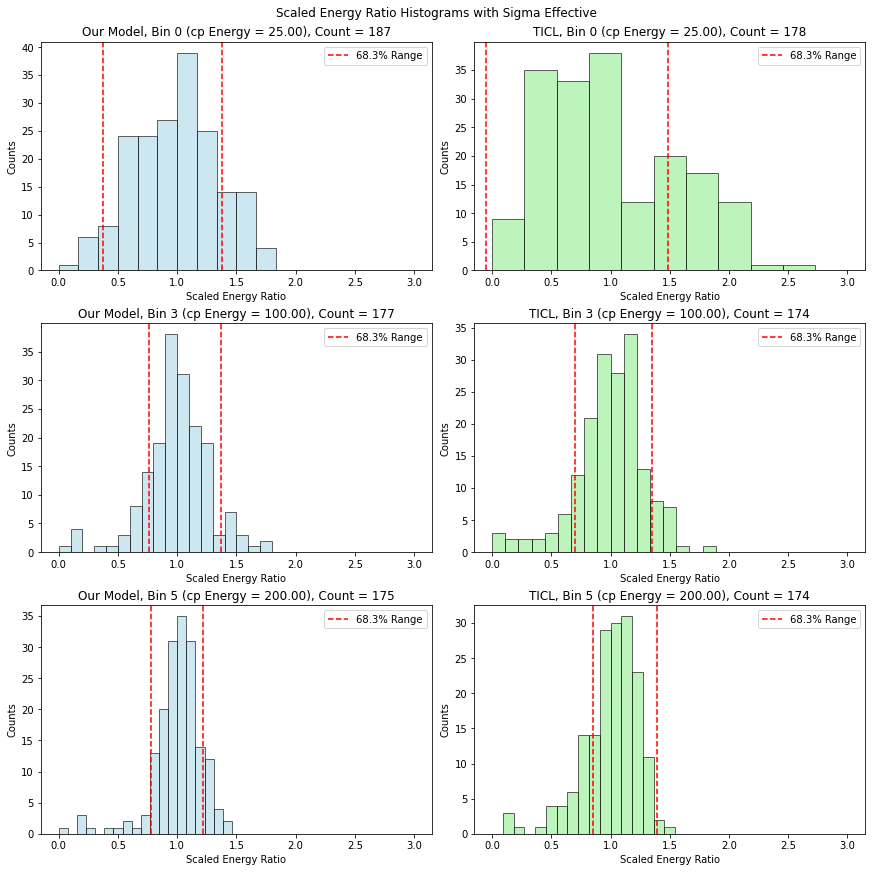

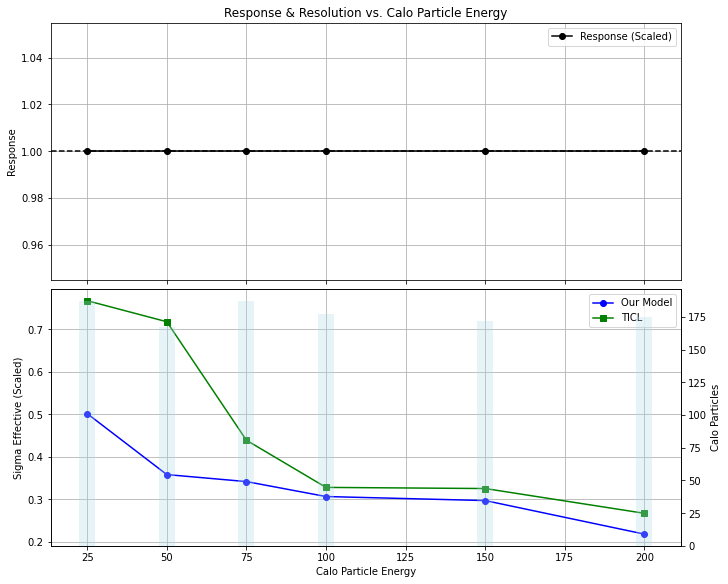

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define allowed energies for CaloParticles
allowed_energies = np.array([25, 50, 75, 100, 150, 200])

def process_cp_dataframe(df):
    """Convert columns to numeric and keep only events with exactly one calo particle id (selecting the row with highest shared_energy if needed)."""
    df = df.copy()
    for col in ['cp_id', 'cp_energy', 'energy_ratio', 'shared_energy']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # For each (event_index, cp_id), keep the row with the highest shared_energy.
    df_cp = df.loc[df.groupby(['event_index', 'cp_id'])['shared_energy'].idxmax()].reset_index(drop=True)
    
    # Only keep events that have exactly one unique cp_id.
    valid_events = df_cp.groupby('event_index')['cp_id'].nunique()
    valid_events = valid_events[valid_events == 1].index
    df_cp = df_cp[df_cp['event_index'].isin(valid_events)]
    
    return df_cp


df_CL_cp = process_cp_dataframe(df_CL)
df_TICL_cp = process_cp_dataframe(df_TICL)

# Map each cp_energy to a bin based on allowed energies
energy_to_bin = {energy: idx for idx, energy in enumerate(allowed_energies)}
df_CL_cp['energy_bin'] = df_CL_cp['cp_energy'].map(energy_to_bin)
df_TICL_cp['energy_bin'] = df_TICL_cp['cp_energy'].map(energy_to_bin)

def compute_scaled_sigma_effective(df, num_bins):
    """
    For each energy bin, scale the energy_ratio data so the mean is 1, then compute the sigma effective
    as the width of the narrowest window covering 68.3% of the data.
    """
    effective_mean_scaled, sigma_eff_scaled, counts = [], [], []
    for b in range(num_bins):
        bin_data = df.loc[df['energy_bin'] == b, 'energy_ratio'].dropna()
        counts.append(len(bin_data))
        if len(bin_data) > 0:
            mean_arith = np.mean(bin_data)
            scaled_data = bin_data / mean_arith
            sorted_data = np.sort(scaled_data)
            n_points = len(sorted_data)
            window_size = max(1, int(0.683 * n_points))
            min_width = np.inf
            best_range = (None, None)
            for i in range(n_points - window_size):
                width = sorted_data[i + window_size] - sorted_data[i]
                if width < min_width:
                    min_width = width
                    best_range = (sorted_data[i], sorted_data[i + window_size])
            mu_eff = (best_range[0] + best_range[1]) / 2 
            sigma_eff_val = (best_range[1] - best_range[0]) /np.sqrt(2)
            effective_mean_scaled.append(mu_eff)
            sigma_eff_scaled.append(sigma_eff_val)
        else:
            effective_mean_scaled.append(np.nan)
            sigma_eff_scaled.append(np.nan)
    return np.array(effective_mean_scaled), np.array(sigma_eff_scaled), np.array(counts)

n_bins = len(allowed_energies)
scaled_fitted_mean_CL, scaled_sigma_eff_CL, counts_CL = compute_scaled_sigma_effective(df_CL_cp, n_bins)
scaled_fitted_mean_TICL, scaled_sigma_eff_TICL, counts_TICL = compute_scaled_sigma_effective(df_TICL_cp, n_bins)

# Plot scaled histograms for selected bins
selected_bins = [0, n_bins // 2, n_bins - 1]
fig_hist, axs = plt.subplots(len(selected_bins), 2, figsize=(12, 4 * len(selected_bins)), constrained_layout=True)

for i, b in enumerate(selected_bins):
    for df, mean_scaled, sigma_scaled, label, color, ax in zip(
            [df_CL_cp, df_TICL_cp],
            [scaled_fitted_mean_CL, scaled_fitted_mean_TICL],
            [scaled_sigma_eff_CL, scaled_sigma_eff_TICL],
            ['Our Model', 'TICL'],
            ['lightblue', 'lightgreen'],
            axs[i] if len(selected_bins) > 1 else [axs]):
        
        bin_data = df.loc[df['energy_bin'] == b, 'energy_ratio'].dropna()
        if len(bin_data) > 0:
            mean_arith = np.mean(bin_data)
            scaled_data = bin_data / mean_arith
        else:
            scaled_data = bin_data
        
        ax.hist(scaled_data, bins='auto', range=(0, 3), color=color, alpha=0.6, edgecolor='k')
        ax.axvline(mean_scaled[b] - sigma_scaled[b], color='r', linestyle='--', label='68.3% Range')
        ax.axvline(mean_scaled[b] + sigma_scaled[b], color='r', linestyle='--')
        ax.set_title(f'{label}, Bin {b} (cp Energy = {allowed_energies[b]:.2f}), Count = {len(scaled_data)}')
        ax.set_xlabel('Scaled Energy Ratio')
        ax.set_ylabel('Counts')
        ax.legend()

plt.suptitle('Scaled Energy Ratio Histograms with Sigma Effective')
plt.show()

# Plot response (fixed at 1) and resolution vs. cp energy
fig_params, (ax_resp, ax_res) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, constrained_layout=True)
ax_resp.plot(allowed_energies, np.ones(n_bins), 'ko-', label='Response (Scaled)')
ax_resp.axhline(1, color='k', linestyle='--')
ax_resp.set_ylabel('Response')
ax_resp.set_title('Response & Resolution vs. Calo Particle Energy')
ax_resp.legend()
ax_resp.grid()

ax_res.plot(allowed_energies, scaled_sigma_eff_CL , 'bo-', label='Our Model')
ax_res.plot(allowed_energies, scaled_sigma_eff_TICL , 'gs-', label='TICL')
ax_res.set_xlabel('Calo Particle Energy')
ax_res.set_ylabel('Sigma Effective (Scaled)')
ax_res.legend()
ax_res.grid()

ax_res2 = ax_res.twinx()
ax_res2.bar(allowed_energies, counts_CL, width=5, color='lightblue', alpha=0.3)
ax_res2.set_ylabel('Calo Particles')

plt.show()


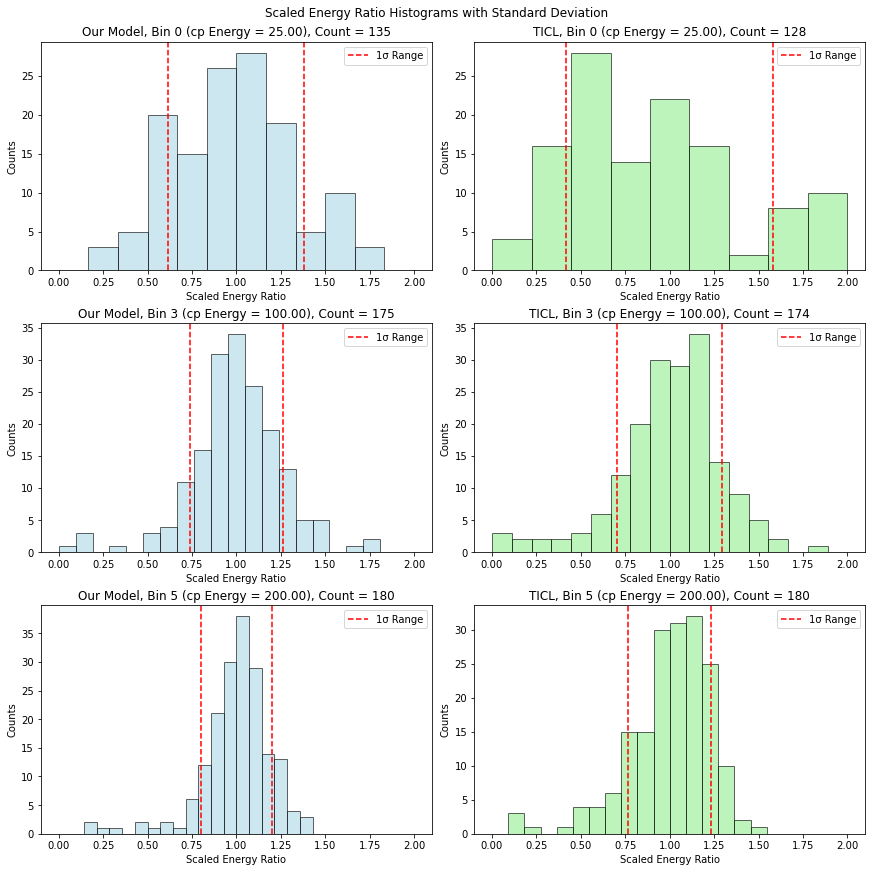

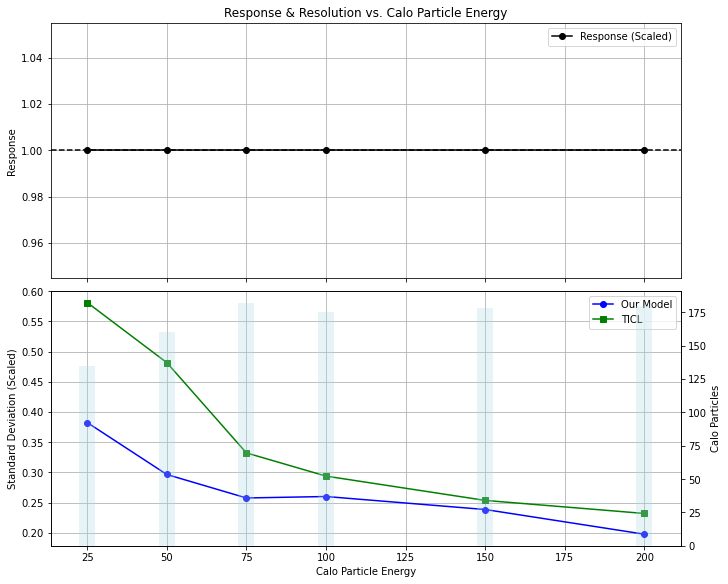

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define allowed energies for CaloParticles
allowed_energies = np.array([25, 50, 75, 100, 150, 200])

def process_cp_dataframe(df):
    """Convert columns to numeric and keep only events with exactly one calo particle id (selecting the row with highest shared_energy if needed)."""
    df = df.copy()
    for col in ['cp_id', 'cp_energy', 'energy_ratio', 'shared_energy']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # For each (event_index, cp_id), keep the row with the highest shared_energy.
    df_cp = df.loc[df.groupby(['event_index', 'cp_id'])['shared_energy'].idxmax()].reset_index(drop=True)
    
    # Only keep events that have exactly one unique cp_id.
    valid_events = df_cp.groupby('event_index')['cp_id'].nunique()
    valid_events = valid_events[valid_events == 1].index
    df_cp = df_cp[df_cp['event_index'].isin(valid_events)]
    
    return df_cp

df_CL_cp = process_cp_dataframe(df_CL)
df_TICL_cp = process_cp_dataframe(df_TICL)

# Map each cp_energy to a bin based on allowed energies
energy_to_bin = {energy: idx for idx, energy in enumerate(allowed_energies)}
df_CL_cp['energy_bin'] = df_CL_cp['cp_energy'].map(energy_to_bin)
df_TICL_cp['energy_bin'] = df_TICL_cp['cp_energy'].map(energy_to_bin)

def compute_scaled_sigma_effective(df, num_bins):
    """
    For each energy bin, scale the energy_ratio data so the mean is 1, then compute the standard deviation
    (using np.sqrt) of the scaled data.
    """
    effective_mean_scaled, sigma_eff_scaled, counts = [], [], []
    for b in range(num_bins):
        bin_data = df.loc[df['energy_bin'] == b, 'energy_ratio'].dropna()
        counts.append(len(bin_data))
        if len(bin_data) > 0:
            mean_arith = np.mean(bin_data)
            scaled_data = bin_data / mean_arith
            mu_eff = np.mean(scaled_data)
            sigma_eff_val = np.std(scaled_data)
            effective_mean_scaled.append(mu_eff)
            sigma_eff_scaled.append(sigma_eff_val)
        else:
            effective_mean_scaled.append(np.nan)
            sigma_eff_scaled.append(np.nan)
    return np.array(effective_mean_scaled), np.array(sigma_eff_scaled), np.array(counts)

n_bins = len(allowed_energies)
scaled_fitted_mean_CL, scaled_sigma_eff_CL, counts_CL = compute_scaled_sigma_effective(df_CL_cp, n_bins)
scaled_fitted_mean_TICL, scaled_sigma_eff_TICL, counts_TICL = compute_scaled_sigma_effective(df_TICL_cp, n_bins)

# Plot scaled histograms for selected bins
selected_bins = [0, n_bins // 2, n_bins - 1]
fig_hist, axs = plt.subplots(len(selected_bins), 2, figsize=(12, 4 * len(selected_bins)), constrained_layout=True)

for i, b in enumerate(selected_bins):
    for df, mean_scaled, sigma_scaled, label, color, ax in zip(
            [df_CL_cp, df_TICL_cp],
            [scaled_fitted_mean_CL, scaled_fitted_mean_TICL],
            [scaled_sigma_eff_CL, scaled_sigma_eff_TICL],
            ['Our Model', 'TICL'],
            ['lightblue', 'lightgreen'],
            axs[i] if len(selected_bins) > 1 else [axs]):
        
        bin_data = df.loc[df['energy_bin'] == b, 'energy_ratio'].dropna()
        if len(bin_data) > 0:
            mean_arith = np.mean(bin_data)
            scaled_data = bin_data / mean_arith
        else:
            scaled_data = bin_data
        
        ax.hist(scaled_data, bins='auto', range=(0, 2), color=color, alpha=0.6, edgecolor='k')
        ax.axvline(mean_scaled[b] - sigma_scaled[b], color='r', linestyle='--', label='1σ Range')
        ax.axvline(mean_scaled[b] + sigma_scaled[b], color='r', linestyle='--')
        ax.set_title(f'{label}, Bin {b} (cp Energy = {allowed_energies[b]:.2f}), Count = {len(scaled_data)}')
        ax.set_xlabel('Scaled Energy Ratio')
        ax.set_ylabel('Counts')
        ax.legend()

plt.suptitle('Scaled Energy Ratio Histograms with Standard Deviation')
plt.show()

# Plot response (fixed at 1) and resolution vs. cp energy
fig_params, (ax_resp, ax_res) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, constrained_layout=True)
ax_resp.plot(allowed_energies, np.ones(n_bins), 'ko-', label='Response (Scaled)')
ax_resp.axhline(1, color='k', linestyle='--')
ax_resp.set_ylabel('Response')
ax_resp.set_title('Response & Resolution vs. Calo Particle Energy')
ax_resp.legend()
ax_resp.grid()

ax_res.plot(allowed_energies, scaled_sigma_eff_CL , 'bo-', label='Our Model')
ax_res.plot(allowed_energies, scaled_sigma_eff_TICL , 'gs-', label='TICL')
ax_res.set_xlabel('Calo Particle Energy')
ax_res.set_ylabel('Standard Deviation (Scaled)')
ax_res.legend()
ax_res.grid()

ax_res2 = ax_res.twinx()
ax_res2.bar(allowed_energies, counts_CL, width=5, color='lightblue', alpha=0.3)
ax_res2.set_ylabel('Calo Particles')

plt.show()
